In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

In [95]:
Ra =  336#95.4586
Dec = 47#-51.2377
Size = 20
Maglim= 16
Bkg_limit = 20.5
Zeropoint = 20.44
Scale = 100
Interpolate = False
tpf = sd.Get_TESS(Ra,Dec,Size)
# pos returned as column row 
pos, gmag = sd.Get_Gaia(tpf,magnitude_limit=Maglim)
col = pos[:,0]
row = pos[:,1]

Tmag = gmag - 0.5
tcounts = 10**(-2/5*(Tmag - Zeropoint))
bkg = 10**(-2/5*(Bkg_limit - Zeropoint))

In [108]:
sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2])) + bkg
for i in range(len(pos)):
    if Interpolate:
        template = np.zeros((2*tpf.shape[1]*Scale,2*tpf.shape[2]*Scale))
        
        offset1 = int(0.5 * tpf.shape[1] * Scale)
        offset2 = int(0.5 * tpf.shape[2] * Scale)
        
        kernal = sd.Interp_PRF(row[i] + tpf.row, col[i] + tpf.column,tpf.camera,tpf.ccd,Scale)
        optics = kernal * tcounts[i]
        r = int(row[i]*Scale + offset1)
        c = int(col[i]*Scale + offset2)
        template = Add_convolved_sources(r,c,optics,template)
        template = template[offset1:int(3*offset1),offset2:int(3*offset2)]
        #print('template shape ',template.shape)
        sources[i] = sd.Downsample(template,Scale)
    else:
        template = np.zeros((2*tpf.shape[1],2*tpf.shape[2]))
        kernal = sd.Get_PRF(row[i] + tpf.row, col[i] + tpf.column,tpf.camera,tpf.ccd)
        kernal = kernal / np.nansum(kernal)
        #print(template.shape)
        offset1 = int(0.5 * tpf.shape[1])
        offset2 = int(0.5 * tpf.shape[2])
        optics = kernal * tcounts[i]
        r = int(row[i] + offset1)
        c = int(col[i] + offset2)
        template = Add_convolved_sources(r,c,optics,template)
        template = template[offset1:int(3*offset1),offset2-1:int(3*offset2-1)]

        sources[i] += template

s2 -1


ValueError: could not broadcast input array from shape (13,12) into shape (13,11)

0 13
1 13
(13, 11)
optics (13, 12)


ValueError: could not broadcast input array from shape (13,12) into shape (13,11)

In [137]:
def Add_convolved_sources(Row, Col, Optics,Template):
    """
    An ugly function that inserts a small array into a larger array.
    With this fft is not needed for single objects.

    -------
    Inputs-
    -------
    Row 		int  	Row of source
    Col 		int  	Column of source
    Optics 		array 	Small array to inject
    Template 	array 	Large array to be get injected 

    -------
    Output-
    -------
    Template 	array 	Large array with small array injected 

    """
    if Optics.shape[0]/2 == int(Optics.shape[0]/2):
        start1 = int(Row - Optics.shape[0]/2)
        end1 = int(Row + Optics.shape[0]/2)
    else:
        start1 = int(Row - (Optics.shape[0]+1)/2)
        end1 = int(Row + (Optics.shape[0]+1)/2)

    if start1 < 0:
        o_start1 = abs(start1)
        start1 = 0
    else:
        o_start1 = 0

    if end1 > Template.shape[0]:
        o_end1 = Optics.shape[0]-abs(end1 - (Template.shape[0]))
        end1 = Template.shape[0]
    else:
        o_end1 = Optics.shape[0]
    if Optics.shape[0]/2 == int(Optics.shape[0]/2):
        start2 = int(Col - Optics.shape[1]/2)
        end2 = int(Col + Optics.shape[1]/2)
    else:
        start2 = int(Col - (Optics.shape[1]+1)/2)
        end2 = int(Col + (Optics.shape[1]+1)/2)

    if start2 < 0:
        print('s2',start2)
        o_start2 = abs(start2)
        start2 = 0
    else:
        o_start2 = 0

    if end2 > Template.shape[1]:
        print('e2')
        o_end2 = Optics.shape[1]-abs(end2 - (Template.shape[1]))
        end2 = Template.shape[1]
    else:
        o_end2 = Optics.shape[1]

    print(o_start1,o_end1)
    print(start2,end2)
    print(o_start2,o_end2)
    print(Template[start1:end1,start2:end2].shape)
    print('optics', Optics[o_start1:o_end1,o_start2:o_end2].shape)
    Template[start1:end1,start2:end2] = Optics[o_start1:o_end1,o_start2:o_end2]

    return Template

In [138]:
template = Add_convolved_sources(r,c,optics,template)

s2 -2
0 13
0 12
2 13
(14, 12)
optics (13, 11)


ValueError: could not broadcast input array from shape (13,11) into shape (14,12)

In [118]:

start1 = int(row[i] + offset1 - optics.shape[0]/2)
end1 = int(row[i] + offset1 + optics.shape[0]/2)

if start1 < 0:
    start1 = 0
    o_start1 = abs(start1)
else:
    o_start1 = 0
    
if end1 >= template.shape[0]:
    end1 = template.shape[0] - 1
    o_end1 = abs(end1 - (template.shape[0] - 1))
else:
    o_end1 = optics.shape[0]

start2 = int(col[i] + offset2 - optics.shape[1]/2)
end2 = int(col[i]+ offset2 + optics.shape[1]/2)

if start2 < 0:
    start2 = 0
    o_start2 = abs(start2)
else:
    o_start2 = 0
    
if end2 >= template.shape[1]:
    end2 = template.shape[1] - 1
    o_end2 = abs(end2 - (template.shape[1] - 1))
else:
    o_end2 = optics.shape[1]
    
print(start1)

26


In [36]:
optics[o_start1:o_end1,o_start2:o_end2].shape

(1200, 1200)

In [28]:
optics.shape

(1200, 1200)

<IPython.core.display.Javascript object>


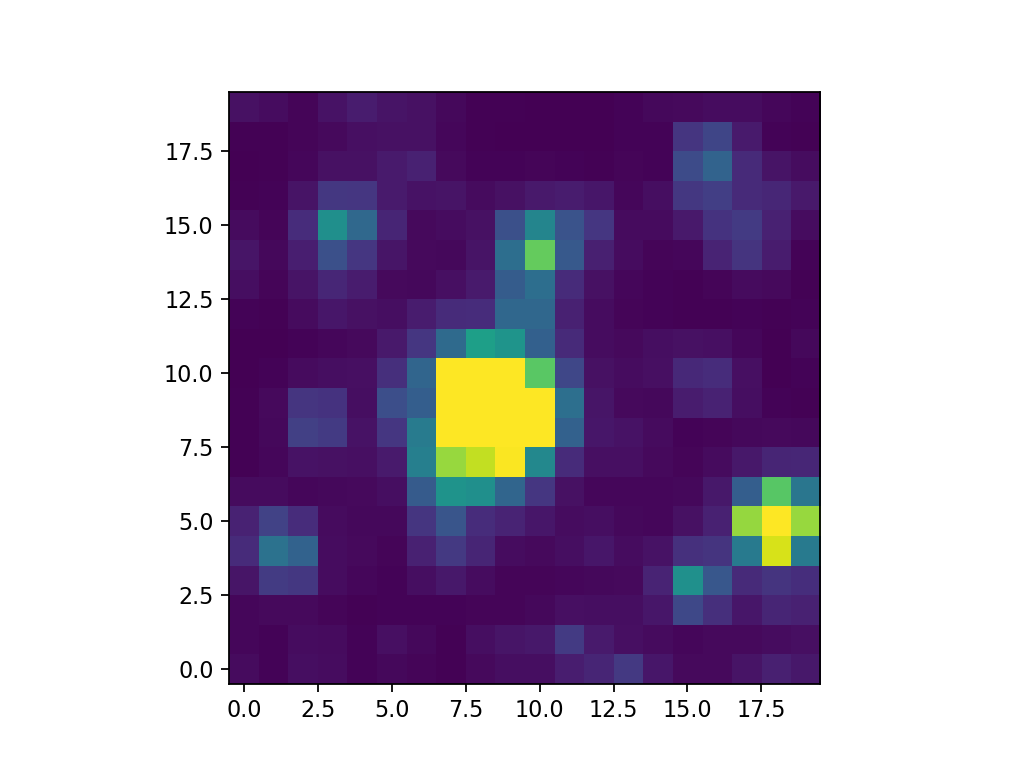

In [94]:
plt.figure()
plt.imshow(np.nansum(sources,axis=0),origin='lower',vmax=1000)